In [5]:
import numpy as np
from scipy.spatial import distance_matrix
from gurobipy import *
from scipy.spatial import ConvexHull
from shapely.geometry import Polygon, Point
from numpy import random
import time
import pandas as pd
import geopandas as gpd
import random
from haversine import haversine

### 1. 부평동

In [2]:
#랜덤 좌표 생성
def generate_candidate_sites_from_shp(shp_file_path, exclusion_shp_paths, M=100):
    # 대상 .shp 파일에서 폴리곤 불러오기
    random.seed(42)
    gdf = gpd.read_file(shp_file_path)
    poly = gdf['geometry'][70]  # 대상 폴리곤 추출
    
    #제외할 .shp 파일들에서 폴리곤들 불러오기
    ex_poligon_list=[]
    for ex_path in exclusion_shp_paths:
        ex= gpd.read_file(ex_path)
        for ex_poly in ex['geometry']:
            ex_poligon_list.append(ex_poly)
    
    

    min_x, min_y, max_x, max_y = poly.bounds
    sites = []
    attempts = 0  # 시도 횟수
    while len(sites) < M:
        random_point = Point(random.uniform(min_x, max_x),
                             random.uniform(min_y, max_y))
        
        # 진행도 체크
        if attempts % 1000 == 0:  # 100번의 시도마다 진행 상황 출력
            print(f"시도 횟수: {attempts}, 유효한 사이트 수: {len(sites)}")

        # 대상 폴리곤 내에 있고 제외할 폴리곤들 내에 없는지 확인
        if random_point.within(poly) :
            if not any(random_point.within(ex_poly) for ex_poly in ex_poligon_list):
                sites.append(random_point)
        attempts += 1  # 시도 횟수 증가

    return np.array([(p.x, p.y) for p in sites])

# 사용 예시
path= 'C:/Users/chldy/OneDrive/바탕 화면/용용/딥러닝 부트캠프/교육데이터공모전/교육 공모전 자료/'
shp_file_path = path+'행정구역_읍면동.shp'
exclusion_shp_paths = [path+'상습침수구역.shp', path+'개발제한구역.shp', path+'공항_소음대책지역.shp']  # 제외할 .shp 파일들의 경로 리스트
M = 200  # 생성할 좌표 수
sites = generate_candidate_sites_from_shp(shp_file_path, exclusion_shp_paths ,M)
print(sites)



시도 횟수: 0, 유효한 사이트 수: 0
[[175689.48484691 541312.4208287 ]
 [174839.23751845 542139.31874853]
 [175915.91823271 544031.29117912]
 [174707.65979951 543316.43661707]
 [175713.88561909 543481.59172833]
 [176077.72775935 544120.73929463]
 [174991.41790529 541856.74142808]
 [176174.96815402 543726.84312557]
 [176080.78209437 544252.54396281]
 [175448.69167537 545267.95123766]
 [175080.74549962 543511.20965683]
 [176132.75951725 543788.56309617]
 [176208.13020835 543616.8102626 ]
 [175841.48752898 541399.25608368]
 [174729.26682614 542415.41266771]
 [175680.75282534 542730.16882373]
 [175061.25451792 542082.1463565 ]
 [175709.57123147 543749.39288536]
 [174578.77905045 542791.17763616]
 [175497.04143213 544064.31187585]
 [176164.13595111 544445.57635177]
 [174933.55806141 542325.10018905]
 [176242.33802793 542520.92317085]
 [175726.84527815 542858.66644393]
 [174815.55653892 542237.01440793]
 [175507.35084652 542304.24305376]
 [175561.52498648 544953.82645701]
 [175129.4323608  542123.0896071

In [3]:
sites_df= pd.DataFrame(data=sites, columns=['경도','위도'])
sites_df

,경도,위도
0,175689.484847,541312.420829
1,174839.237518,542139.318749
2,175915.918233,544031.291179
3,174707.659800,543316.436617
4,175713.885619,543481.591728
...,...,...
195,174650.446446,542157.143471
196,175443.808081,542352.512361
197,176470.831455,543516.709803
198,175824.794092,541734.917881


In [41]:
from pyproj import Proj, transform

# 좌표 변환 함수 정의
def convert_coords(x, y):
    proj_UTM = Proj(init='epsg:5186')  # 원본 좌표계
    proj_WGS84 = Proj(init='epsg:4326')  # 목표 좌표계
    lon, lat = transform(proj_UTM, proj_WGS84, x, y)
    return pd.Series([lat, lon])

    # 새로운 'latitude'와 'longitude' 컬럼을 생성하고 변환된 좌표를 적용
sites_df[['latitude', 'longitude']] = sites_df.apply(lambda row: convert_coords(row['경도'], row['위도']), axis=1)

print(sites_df)

c:\Users\chldy\anaconda3\envs\mclp\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
c:\Users\chldy\anaconda3\envs\mclp\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\chldy\AppData\Local\Temp\ipykernel_20540\519013629.py:7: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pypro

                경도             위도   latitude   longitude
0    175689.484847  541312.420829  37.470923  126.725180
1    174839.237518  542139.318749  37.478351  126.715540
2    175915.918233  544031.291179  37.495426  126.727651
3    174707.659800  543316.436617  37.488953  126.714012
4    175713.885619  543481.591728  37.490468  126.725384
..             ...            ...        ...         ...
195  174650.446446  542157.143471  37.478506  126.713405
196  175443.808081  542352.512361  37.480288  126.722368
197  176470.831455  543516.709803  37.490804  126.733942
198  175824.794092  541734.917881  37.474733  126.726696
199  176223.889985  543256.039714  37.488449  126.731159

[200 rows x 4 columns]


c:\Users\chldy\anaconda3\envs\mclp\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
c:\Users\chldy\anaconda3\envs\mclp\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\chldy\AppData\Local\Temp\ipykernel_20540\519013629.py:7: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pypro

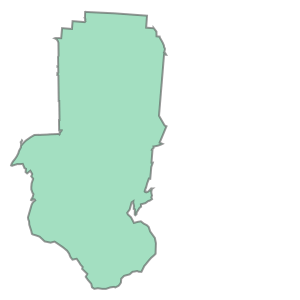

In [37]:
ex= path+'행정구역_읍면동.shp'
gpff= gpd.read_file(ex)
gpff['geometry'][70]

In [42]:
# 아파트 좌표
apt= pd.read_csv('data/인천_아파트.csv')
apt.drop(['Unnamed: 0'], axis=1, inplace=True)
apt= apt[apt['legal_dong']=='부평동']
apt_points= np.array([list(i) for i in zip (apt['la'],apt['lo'])])
apt_points

array([[ 37.49641145, 126.72984233],
       [ 37.49091882, 126.71850116],
       [ 37.49081395, 126.71892222],
       [ 37.4914431 , 126.72748851],
       [ 37.49087875, 126.72752891],
       [ 37.49079964, 126.72840547],
       [ 37.50095247, 126.72159699],
       [ 37.5011451 , 126.72237192],
       [ 37.50179182, 126.72218726],
       [ 37.50253875, 126.7220125 ],
       [ 37.50286994, 126.72206628],
       [ 37.50321458, 126.72200652],
       [ 37.50430416, 126.72192006],
       [ 37.50492669, 126.72100499],
       [ 37.49053562, 126.73067746],
       [ 37.49071793, 126.73147446],
       [ 37.49023988, 126.73146194],
       [ 37.49014941, 126.73176231],
       [ 37.49007419, 126.73198693],
       [ 37.49023942, 126.73272792],
       [ 37.48979858, 126.73278954],
       [ 37.49015718, 126.73297206],
       [ 37.49011293, 126.73339555],
       [ 37.48381954, 126.71617309],
       [ 37.48453593, 126.71740435],
       [ 37.48642931, 126.7198176 ],
       [ 37.48718189, 126.72296349],
 

In [43]:
# 지하철 좌표
train= pd.read_csv('data/인천_지하철역.csv')
train.drop(['Unnamed: 0'],axis=1)
train= train[train['legal_dong']=='부평동']
train_points= np.array([list(i) for i in zip (train['lon'],train['lat'])])
train_points


array([[ 37.48519431, 126.71795245],
       [ 37.49044727, 126.72348637],
       [ 37.49841586, 126.72226437]])

In [44]:
#버스 정류장 좌표
bus= pd.read_csv('data/인천_버스정류장.csv')
bus.drop(['Unnamed: 0'],axis=1, inplace=True)
bus= bus[bus['legal_dong']=='부평동']
bus_points= np.array([list(i) for i in zip (bus['위도'],bus['경도'])])
bus_points


array([[ 37.4829667, 126.7143167],
       [ 37.4847833, 126.7174   ],
       [ 37.4850833, 126.7172833],
       [ 37.485    , 126.7198333],
       [ 37.4852167, 126.7195167],
       [ 37.4847833, 126.7210333],
       [ 37.485    , 126.7215667],
       [ 37.4851333, 126.7242333],
       [ 37.4853167, 126.7240333],
       [ 37.49065  , 126.712    ],
       [ 37.4852   , 126.7301   ],
       [ 37.4853667, 126.7299   ],
       [ 37.4912333, 126.7172833],
       [ 37.487    , 126.73055  ],
       [ 37.4873333, 126.7312   ],
       [ 37.48805  , 126.7295333],
       [ 37.4911   , 126.7203667],
       [ 37.4911333, 126.72155  ],
       [ 37.4913667, 126.7213833],
       [ 37.49115  , 126.72505  ],
       [ 37.4920667, 126.7244667],
       [ 37.4926   , 126.7232167],
       [ 37.49095  , 126.72845  ],
       [ 37.4912333, 126.7283333],
       [ 37.4931167, 126.72275  ],
       [ 37.4924667, 126.7248667],
       [ 37.4904167, 126.7317833],
       [ 37.4926333, 126.7246333],
       [ 37.4931   ,

In [15]:
# 가중치 도보+자전거 0.601  버스 0.311, 0.088 지하철 
m1= 0.311
m2= 0.088
m3= 0.601

In [13]:
def mclp(버스_points, 지하철_points,주택_points, K, radius):

    print('  K %g' % K)
    print('  Radius %g' % radius)

    start = time.time()
    sites = np.array([list(i) for i in zip(sites_df['latitude'], sites_df['longitude'])])
    J = sites.shape[0]                             
    
    # 수요지점 수
    A = 버스_points.shape[0]
    B = 지하철_points.shape[0]
    C = 주택_points.shape[0]
    
    # 입지후보지와 수요지점 간 거리 계산
    D1 = []
    for i in 버스_points:
        site = []
        for j in sites:
            site.append(haversine(i, j, unit='m'))
        D1.append(site)
    D1 = np.array(D1)
    
    D2 = []
    for i in 지하철_points:
        site = []
        for j in sites:
            site.append(haversine(i, j, unit='m'))
        D2.append(site)
    D2 = np.array(D2)    
    

    
    D3 = []
    for i in 주택_points:
        site = []
        for j in sites:
            site.append(haversine(i, j, unit='m'))
        D3.append(site)
    D3 = np.array(D3)

    for i in [D1, D2, D3]:
        mask1 = i<=radius
        i[mask1]=1                                                 
        i[~mask1]=0

    m = Model()
    x1, x2, x3 = {}, {}, {}
    y = {}
    
    # 수요지점 변수 추가
    for i in range(A):                                       
        x1[i] = m.addVar(vtype=GRB.BINARY, name="x1%d" % i)
    for i in range(B):                                       
        x2[i] = m.addVar(vtype=GRB.BINARY, name="x2%d" % i)
    
    for i in range(C):                                       
        x3[i] = m.addVar(vtype=GRB.BINARY, name="x3%d" % i)
    
    # 입지후보지 변수 추가
    for j in range(J):
        y[j] = m.addVar(vtype=GRB.BINARY, name="y%d" % j)

    m.update()
    m.addConstr(quicksum(y[j] for j in range(J)) == K) 

    # 수요지점 제약 조건
    for i in range(A): 
        m.addConstr(quicksum(y[j] for j in np.where(D1[i]==1)[0]) >= x1[i])
    for i in range(B): 
        m.addConstr(quicksum(y[j] for j in np.where(D2[i]==1)[0]) >= x2[i])
    
    for i in range(C): 
        m.addConstr(quicksum(y[j] for j in np.where(D3[i]==1)[0]) >= x3[i])
    
    # 목적함수 수정
    m.setObjective(quicksum(i for i in [m1*x1[a] for a in range(A)] + [m2*x2[b] for b in range(B)]  + [m3*x3[c] for c in range(C)]), GRB.MAXIMIZE)


    m.setParam('OutputFlag', 0)
    m.optimize()
    end = time.time()
    print('----- Output -----')
    print('  Running time : %s seconds' % float(end-start))
    print('Optimal coverage points: %g' % m.objVal)

    solution = []
    if m.status == GRB.Status.OPTIMAL:
        for v in m.getVars():
            if v.x==1 and v.varName[0]=="y":
                solution.append(int(v.varName[1:]))
    opt_sites = sites[solution]
    return opt_sites,m.objVal

In [51]:
opts_sites, mobjVal = mclp(bus_points, train_points,apt_points, 1, 1000)
opts_sites

  K 2
  Radius 1000
----- Output -----
  Running time : 0.8908898830413818 seconds
Optimal coverage points: 235.556


array([[ 37.49881412, 126.72666214],
       [ 37.48815119, 126.72244564]])

In [52]:
df= pd.DataFrame(data=opts_sites, columns= ['위도','경도'])
df.to_csv('부평동_최종_입지.csv')

### 만수동

In [6]:
#랜덤 좌표 생성
def generate_candidate_sites_from_shp(shp_file_path, exclusion_shp_paths, M=100):
    # 대상 .shp 파일에서 폴리곤 불러오기
    random.seed(42)
    gdf = gpd.read_file(shp_file_path)
    poly = gdf['geometry'][2]  # 대상 폴리곤 추출
    
    # 제외할 .shp 파일들에서 폴리곤들 불러오기
    ex_poligon_list=[]
    for ex_path in exclusion_shp_paths:
        ex= gpd.read_file(ex_path)
        for ex_poly in ex['geometry']:
            ex_poligon_list.append(ex_poly)
    
    

    min_x, min_y, max_x, max_y = poly.bounds
    sites = []
    attempts = 0  # 시도 횟수
    while len(sites) < M:
        random_point = Point(random.uniform(min_x, max_x),
                             random.uniform(min_y, max_y))
        
        # 진행도 체크
        if attempts % 1000 == 0:  # 100번의 시도마다 진행 상황 출력
            print(f"시도 횟수: {attempts}, 유효한 사이트 수: {len(sites)}")

        # 대상 폴리곤 내에 있고 제외할 폴리곤들 내에 없는지 확인
        if random_point.within(poly) :
            if not any(random_point.within(ex_poly) for ex_poly in ex_poligon_list):
                sites.append(random_point)
        attempts += 1  # 시도 횟수 증가

    return np.array([(p.x, p.y) for p in sites])

# 사용 예시
path= 'C:/Users/chldy/OneDrive/바탕 화면/용용/딥러닝 부트캠프/교육데이터공모전/교육 공모전 자료/'
shp_file_path = path+'행정구역_읍면동.shp'
exclusion_shp_paths = [path+'상습침수구역.shp', path+'개발제한구역.shp', path+'공항_소음대책지역.shp']  # 제외할 .shp 파일들의 경로 리스트
M = 200  # 생성할 좌표 수
sites = generate_candidate_sites_from_shp(shp_file_path, exclusion_shp_paths, M)
print(sites)



시도 횟수: 0, 유효한 사이트 수: 0
[[175881.9276196  539350.88744238]
 [175886.63385059 539723.23201156]
 [176299.37446592 539558.04930629]
 [176970.72468336 538727.3292283 ]
 [176008.13006369 541264.73793043]
 [175757.91955065 540343.8526842 ]
 [176765.1693868  540146.33240118]
 [175861.94211438 541292.49447247]
 [177022.29768405 538864.00012763]
 [176776.70462528 538274.31182658]
 [176837.32025293 541092.42585867]
 [175597.38682496 539892.65379483]
 [176007.73158201 539952.62870765]
 [176495.67374374 541340.88977811]
 [176618.0189848  537901.17148736]
 [176090.2819254  539943.69929727]
 [176900.98094881 537786.63042485]
 [175491.81761982 540483.52169627]
 [176551.95768388 539548.12265942]
 [176003.11434105 540979.7607963 ]
 [176719.08040361 540347.4215625 ]
 [176454.884634   539405.11500828]
 [176193.77340154 539718.98556661]
 [175496.46620661 539908.8810172 ]
 [175908.82811586 541126.13741311]
 [175932.4888007  540076.94700936]
 [176545.14014107 540590.09604722]
 [176416.97297393 539180.7988844

In [7]:
sites_df= pd.DataFrame(data=sites, columns=['경도','위도'])

In [8]:
from pyproj import Proj, transform

# 좌표 변환 함수 정의
def convert_coords(x, y):
    proj_UTM = Proj(init='epsg:5186')  # 원본 좌표계
    proj_WGS84 = Proj(init='epsg:4326')  # 목표 좌표계
    lon, lat = transform(proj_UTM, proj_WGS84, x, y)
    return pd.Series([lat, lon])

    # 새로운 'latitude'와 'longitude' 컬럼을 생성하고 변환된 좌표를 적용
sites_df[['latitude', 'longitude']] = sites_df.apply(lambda row: convert_coords(row['경도'], row['위도']), axis=1)

print(sites_df)

c:\Users\chldy\anaconda3\envs\mclp\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
c:\Users\chldy\anaconda3\envs\mclp\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\chldy\AppData\Local\Temp\ipykernel_18948\519013629.py:7: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pypro

                경도             위도   latitude   longitude
0    175881.927620  539350.887442  37.453255  126.727420
1    175886.633851  539723.232012  37.456609  126.727461
2    176299.374466  539558.049306  37.455132  126.732131
3    176970.724683  538727.329228  37.447664  126.739745
4    176008.130064  541264.737930  37.470502  126.728784
..             ...            ...        ...         ...
195  176588.676758  538919.396647  37.449385  126.735421
196  176278.477065  539075.891565  37.450787  126.731910
197  175570.510617  540151.062741  37.460456  126.723874
198  176247.523905  538875.127998  37.448977  126.731567
199  175639.875868  539613.682606  37.455616  126.724675

[200 rows x 4 columns]


c:\Users\chldy\anaconda3\envs\mclp\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
c:\Users\chldy\anaconda3\envs\mclp\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\chldy\AppData\Local\Temp\ipykernel_18948\519013629.py:7: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pypro

In [9]:
#아파트 좌표
apt= pd.read_csv('data/인천_아파트.csv')
apt.drop(['Unnamed: 0'], axis=1, inplace=True)
apt= apt[apt['legal_dong']=='만수동']
apt_points= np.array([list(i) for i in zip (apt['la'],apt['lo'])])
apt_points

array([[ 37.44921966, 126.73295724],
       [ 37.45169949, 126.72648214],
       [ 37.45167541, 126.72677636],
       [ 37.45164405, 126.72707508],
       [ 37.45198231, 126.72749947],
       [ 37.46429623, 126.72313986],
       [ 37.43847555, 126.73717716],
       [ 37.45753859, 126.72485995],
       [ 37.44053721, 126.73959107],
       [ 37.44984664, 126.7392879 ],
       [ 37.4498875 , 126.73915775],
       [ 37.45843344, 126.73199056],
       [ 37.46253137, 126.73677108],
       [ 37.46386839, 126.73693583],
       [ 37.46358827, 126.73752636],
       [ 37.46395892, 126.7381234 ],
       [ 37.4644785 , 126.73833264],
       [ 37.46500354, 126.73853845],
       [ 37.46041175, 126.72832213],
       [ 37.46064217, 126.73010409],
       [ 37.46317302, 126.73127027],
       [ 37.46190307, 126.73758886],
       [ 37.46253751, 126.72409277],
       [ 37.46336014, 126.72453225],
       [ 37.45034383, 126.73391319],
       [ 37.44247487, 126.73497372],
       [ 37.44273797, 126.73494006],
 

In [10]:
# 지하철 좌표
train= pd.read_csv('data/인천_지하철역.csv')
train.drop(['Unnamed: 0'],axis=1)
train= train[train['legal_dong']=='만수동']
train_points= np.array([list(i) for i in zip (train['lon'],train['lat'])])
train_points


array([[ 37.44817192, 126.73663642],
       [ 37.45496238, 126.73190368]])

In [11]:
#버스 정류장 좌표
bus= pd.read_csv('data/인천_버스정류장.csv')
bus.drop(['Unnamed: 0'],axis=1, inplace=True)
bus= bus[bus['legal_dong']=='만수동']
bus_points= np.array([list(i) for i in zip (bus['위도'],bus['경도'])])
bus_points

array([[ 37.4394167, 126.7368   ],
       [ 37.4397   , 126.73785  ],
       [ 37.4422167, 126.73855  ],
       [ 37.4422833, 126.7388833],
       [ 37.4433167, 126.7362833],
       [ 37.4435333, 126.7366   ],
       [ 37.4457333, 126.7327833],
       [ 37.4445   , 126.7389167],
       [ 37.4446167, 126.7386333],
       [ 37.44675  , 126.7328167],
       [ 37.4483   , 126.7306667],
       [ 37.4486333, 126.7305   ],
       [ 37.4491667, 126.7294833],
       [ 37.4481667, 126.7331833],
       [ 37.44585  , 126.74055  ],
       [ 37.4485   , 126.7329   ],
       [ 37.4460167, 126.7407667],
       [ 37.4495833, 126.7297   ],
       [ 37.44805  , 126.7348   ],
       [ 37.4483833, 126.7349833],
       [ 37.4472167, 126.73985  ],
       [ 37.4504833, 126.7296167],
       [ 37.45045  , 126.7297833],
       [ 37.4474333, 126.7397333],
       [ 37.4490833, 126.7343667],
       [ 37.4479333, 126.7381833],
       [ 37.4482667, 126.7382667],
       [ 37.4517333, 126.72715  ],
       [ 37.4518667,

In [22]:
opts_sites, mobjVal = mclp(bus_points, train_points,apt_points, 2, 1000)
opts_sites


  K 2
  Radius 1000
----- Output -----
  Running time : 0.17470836639404297 seconds
Optimal coverage points: 109.46


array([[ 37.44564043, 126.73441567],
       [ 37.46075305, 126.73093135]])

In [17]:
df= pd.DataFrame(data= opts_sites, columns=['위도','경도'])
df.to_csv('만수동_최종입지.csv')

### 구월동

In [72]:
#랜덤 좌표 생성
def generate_candidate_sites_from_shp(shp_file_path, exclusion_shp_paths, M=100):
    # 대상 .shp 파일에서 폴리곤 불러오기
    random.seed(42)
    gdf = gpd.read_file(shp_file_path)
    poly = gdf['geometry'][43]  # 대상 폴리곤 추출
    
    # 제외할 .shp 파일들에서 폴리곤들 불러오기
    ex_poligon_list=[]
    for ex_path in exclusion_shp_paths:
        ex= gpd.read_file(ex_path)
        for ex_poly in ex['geometry']:
            ex_poligon_list.append(ex_poly)
    
    

    min_x, min_y, max_x, max_y = poly.bounds
    sites = []
    attempts = 0  # 시도 횟수
    while len(sites) < M:
        random_point = Point(random.uniform(min_x, max_x),
                             random.uniform(min_y, max_y))
        
        # 진행도 체크
        if attempts % 1000 == 0:  # 100번의 시도마다 진행 상황 출력
            print(f"시도 횟수: {attempts}, 유효한 사이트 수: {len(sites)}")

        # 대상 폴리곤 내에 있고 제외할 폴리곤들 내에 없는지 확인
        if random_point.within(poly) :
            if not any(random_point.within(ex_poly) for ex_poly in ex_poligon_list):
                sites.append(random_point)
        attempts += 1  # 시도 횟수 증가

    return np.array([(p.x, p.y) for p in sites])

# 사용 예시
path= 'C:/Users/chldy/OneDrive/바탕 화면/용용/딥러닝 부트캠프/교육데이터공모전/교육 공모전 자료/'
shp_file_path = path+'행정구역_읍면동.shp'
exclusion_shp_paths = [path+'상습침수구역.shp', path+'개발제한구역.shp', path+'공항_소음대책지역.shp']  # 제외할 .shp 파일들의 경로 리스트
M = 1000  # 생성할 좌표 수
sites = generate_candidate_sites_from_shp(shp_file_path, exclusion_shp_paths, M)
print(sites)



시도 횟수: 0, 유효한 사이트 수: 0
시도 횟수: 1000, 유효한 사이트 수: 485
시도 횟수: 2000, 유효한 사이트 수: 950
[[173704.59940187 537914.85919888]
 [175222.85237004 539259.28219382]
 [173519.05854499 538751.31130814]
 ...
 [174815.87275905 538023.03836928]
 [174604.59122249 537956.15169087]
 [174350.52562317 539070.68640999]]


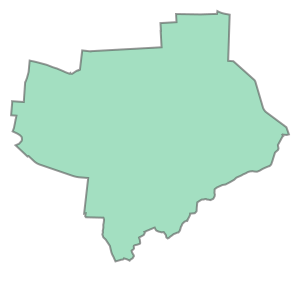

In [104]:
path= 'C:/Users/USER/Desktop/용용/딥러닝부트캠프/교육공공데이터공모전/교육 공모전 자료/'
ex= path+'행정구역_읍면동.shp'
gpff= gpd.read_file(ex)
gpff['geometry'][43]

In [63]:
sites_df= pd.DataFrame(data=sites, columns=['경도','위도'])

In [73]:
from pyproj import Proj, transform

# 좌표 변환 함수 정의
def convert_coords(x, y):
    proj_UTM = Proj(init='epsg:5186')  # 원본 좌표계
    proj_WGS84 = Proj(init='epsg:4326')  # 목표 좌표계
    lon, lat = transform(proj_UTM, proj_WGS84, x, y)
    return pd.Series([lat, lon])

    # 새로운 'latitude'와 'longitude' 컬럼을 생성하고 변환된 좌표를 적용
sites_df[['latitude', 'longitude']] = sites_df.apply(lambda row: convert_coords(row['경도'], row['위도']), axis=1)

print(sites_df)

c:\Users\chldy\anaconda3\envs\mclp\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
c:\Users\chldy\anaconda3\envs\mclp\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\chldy\AppData\Local\Temp\ipykernel_20540\519013629.py:7: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pypro

                경도             위도   latitude   longitude
0    173704.599402  537914.859199  37.440257  126.702863
1    175222.852370  539259.282194  37.452412  126.719974
2    173519.058545  538751.311308  37.447788  126.700737
3    174937.961398  538868.669429  37.448885  126.716768
4    173524.989681  539000.073964  37.450029  126.700795
..             ...            ...        ...         ...
195  172921.491176  538742.227295  37.447689  126.693984
196  174741.521090  539831.456804  37.457554  126.714515
197  174530.191363  538607.742896  37.446523  126.712168
198  173913.634430  539306.731308  37.452803  126.705176
199  174937.804173  539778.286236  37.457080  126.716735

[200 rows x 4 columns]


c:\Users\chldy\anaconda3\envs\mclp\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
c:\Users\chldy\anaconda3\envs\mclp\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\chldy\AppData\Local\Temp\ipykernel_20540\519013629.py:7: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pypro

In [74]:
#아파트 좌표
apt= pd.read_csv('data/인천_아파트.csv')
apt.drop(['Unnamed: 0'], axis=1, inplace=True)
apt= apt[apt['legal_dong']=='구월동']
apt_points= np.array([list(i) for i in zip (apt['la'],apt['lo'])])
apt_points

array([[ 37.4566462 , 126.72081939],
       [ 37.44955346, 126.71542014],
       [ 37.44826398, 126.72634881],
       [ 37.44833368, 126.72645672],
       [ 37.45301304, 126.70222306],
       [ 37.45347627, 126.70346765],
       [ 37.45345996, 126.70368632],
       [ 37.45293643, 126.70378799],
       [ 37.45264418, 126.7054278 ],
       [ 37.45284296, 126.70615405],
       [ 37.45509593, 126.71218014],
       [ 37.45453808, 126.71685375],
       [ 37.45823601, 126.72057763],
       [ 37.4540115 , 126.69947504],
       [ 37.45068312, 126.70509462],
       [ 37.45143157, 126.70410879],
       [ 37.45153487, 126.70410413],
       [ 37.45170389, 126.70508025],
       [ 37.45246428, 126.70519083],
       [ 37.45491113, 126.7025913 ],
       [ 37.44125818, 126.7106041 ],
       [ 37.44654835, 126.7109302 ],
       [ 37.44743469, 126.71335475],
       [ 37.44009148, 126.7136059 ],
       [ 37.44038259, 126.71617506],
       [ 37.44206128, 126.7134263 ],
       [ 37.44408413, 126.7133959 ],
 

In [75]:
# 지하철 좌표
train= pd.read_csv('data/인천_지하철역.csv')
train.drop(['Unnamed: 0'],axis=1)
train= train[train['legal_dong']=='구월동']
train_points= np.array([list(i) for i in zip (train['lon'],train['lat'])])
train_points


array([[ 37.44944591, 126.70116335],
       [ 37.45587968, 126.71951424],
       [ 37.45678003, 126.71049663]])

In [76]:
#버스 정류장 좌표
bus= pd.read_csv('data/인천_버스정류장.csv')
bus.drop(['Unnamed: 0'],axis=1, inplace=True)
bus= bus[bus['legal_dong']=='구월동']
bus_points= np.array([list(i) for i in zip (bus['위도'],bus['경도'])])
bus_points

array([[ 37.44195  , 126.7028667],
       [ 37.4443167, 126.69785  ],
       [ 37.4459833, 126.6945167],
       [ 37.4460833, 126.6939833],
       [ 37.44295  , 126.7044333],
       [ 37.4432   , 126.7049667],
       [ 37.4444333, 126.7071   ],
       [ 37.44455  , 126.7066833],
       [ 37.4487   , 126.7007   ],
       [ 37.4490833, 126.7011   ],
       [ 37.4475833, 126.7070667],
       [ 37.4480167, 126.7076   ],
       [ 37.4492833, 126.7125333],
       [ 37.4497   , 126.7120833],
       [ 37.4520667, 126.7077667],
       [ 37.4543833, 126.7085   ],
       [ 37.4553333, 126.70825  ],
       [ 37.4566   , 126.7048333],
       [ 37.4520667, 126.7208833],
       [ 37.4522   , 126.72125  ],
       [ 37.45215  , 126.7221   ],
       [ 37.4519667, 126.7228333],
       [ 37.45345  , 126.7188833],
       [ 37.4534333, 126.7192833],
       [ 37.4566333, 126.7106667],
       [ 37.45695  , 126.7102667],
       [ 37.4562667, 126.71405  ],
       [ 37.4565333, 126.7141167],
       [ 37.4558833,

In [77]:
opts_sites, mobjVal = mclp(bus_points, train_points,apt_points, 2, 1000)
opts_sites

  K 2
  Radius 1000
----- Output -----
  Running time : 0.17499566078186035 seconds
Optimal coverage points: 97.646


array([[ 37.44893283, 126.70379275],
       [ 37.45158505, 126.71827179]])

In [78]:
df= pd.DataFrame(data= opts_sites, columns= ['위도','경도'])
df.to_csv('구월동_최종입지.csv')

### 간석동

In [79]:
#랜덤 좌표 생성
def generate_candidate_sites_from_shp(shp_file_path, exclusion_shp_paths, M=100):
    # 대상 .shp 파일에서 폴리곤 불러오기
    random.seed(42)
    gdf = gpd.read_file(shp_file_path)
    poly = gdf['geometry'][49]  # 대상 폴리곤 추출
    
    # 제외할 .shp 파일들에서 폴리곤들 불러오기
    ex_poligon_list=[]
    for ex_path in exclusion_shp_paths:
        ex= gpd.read_file(ex_path)
        for ex_poly in ex['geometry']:
            ex_poligon_list.append(ex_poly)
    
    

    min_x, min_y, max_x, max_y = poly.bounds
    sites = []
    attempts = 0  # 시도 횟수
    while len(sites) < M:
        random_point = Point(random.uniform(min_x, max_x),
                             random.uniform(min_y, max_y))
        
        # 진행도 체크
        if attempts % 1000 == 0:  # 100번의 시도마다 진행 상황 출력
            print(f"시도 횟수: {attempts}, 유효한 사이트 수: {len(sites)}")

        # 대상 폴리곤 내에 있고 제외할 폴리곤들 내에 없는지 확인
        if random_point.within(poly) :
            if not any(random_point.within(ex_poly) for ex_poly in ex_poligon_list):
                sites.append(random_point)
        attempts += 1  # 시도 횟수 증가

    return np.array([(p.x, p.y) for p in sites])

# 사용 예시
path= 'C:/Users/chldy/OneDrive/바탕 화면/용용/딥러닝 부트캠프/교육데이터공모전/교육 공모전 자료/'
shp_file_path = path+'행정구역_읍면동.shp'
exclusion_shp_paths = [path+'상습침수구역.shp', path+'개발제한구역.shp', path+'공항_소음대책지역.shp']  # 제외할 .shp 파일들의 경로 리스트
M = 200  # 생성할 좌표 수
sites = generate_candidate_sites_from_shp(shp_file_path, exclusion_shp_paths, M)
print(sites)



시도 횟수: 0, 유효한 사이트 수: 0
[[174640.89636526 541392.86611642]
 [173545.80736929 539560.18112326]
 [172838.08417702 540907.44512117]
 [174339.44855554 541019.59346957]
 [172844.36000901 541145.16468208]
 [174882.32831292 541453.60573474]
 [173261.47254953 539916.24113502]
 [175027.4182737  541186.13108946]
 [174886.8856098  541543.1075112 ]
 [173394.75601884 541039.70548268]
 [174964.43982246 541228.04194958]
 [175076.89854555 541111.41342703]
 [174290.01194267 540509.3407922 ]
 [173365.67401255 540069.30203789]
 [174333.01116568 541201.44347246]
 [175011.25581467 541674.18588621]
 [175127.93917756 540367.25282289]
 [174358.78533869 540596.59692232]
 [175260.86093285 540775.70010709]
 [174031.28318706 540220.116491  ]
 [173467.4004667  540097.10449528]
 [172458.64461574 541253.33027724]
 [174834.49353772 540671.75137823]
 [175544.85626683 540974.75492879]
 [174450.24904572 540997.01106715]
 [175126.14732201 540221.95070571]
 [173819.67342515 539981.88887889]
 [174197.00759132 539908.7613155

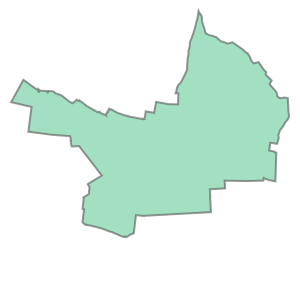

In [116]:
path= 'C:/Users/USER/Desktop/용용/딥러닝부트캠프/교육공공데이터공모전/교육 공모전 자료/'
ex= path+'행정구역_읍면동.shp'
gpff= gpd.read_file(ex)
gpff['geometry'][49]

In [80]:
sites_df= pd.DataFrame(data=sites, columns=['경도','위도'])

In [81]:
from pyproj import Proj, transform

# 좌표 변환 함수 정의
def convert_coords(x, y):
    proj_UTM = Proj(init='epsg:5186')  # 원본 좌표계
    proj_WGS84 = Proj(init='epsg:4326')  # 목표 좌표계
    lon, lat = transform(proj_UTM, proj_WGS84, x, y)
    return pd.Series([lat, lon])

    # 새로운 'latitude'와 'longitude' 컬럼을 생성하고 변환된 좌표를 적용
sites_df[['latitude', 'longitude']] = sites_df.apply(lambda row: convert_coords(row['경도'], row['위도']), axis=1)

print(sites_df)

c:\Users\chldy\anaconda3\envs\mclp\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
c:\Users\chldy\anaconda3\envs\mclp\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\chldy\AppData\Local\Temp\ipykernel_20540\519013629.py:7: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pypro

                경도             위도   latitude   longitude
0    174640.896365  541392.866116  37.471620  126.713324
1    173545.807369  539560.181123  37.455076  126.701010
2    172838.084177  540907.445121  37.467195  126.692962
3    174339.448556  541019.593470  37.468248  126.709929
4    172844.360009  541145.164682  37.469337  126.693024
..             ...            ...        ...         ...
195  174417.629320  541131.833660  37.469262  126.710809
196  173128.967250  540632.474119  37.464726  126.696260
197  173136.537356  540871.378922  37.466878  126.696337
198  174411.172692  541581.093549  37.473309  126.710720
199  175370.270808  540663.158234  37.465065  126.721593

[200 rows x 4 columns]


In [82]:
#아파트 좌표
apt= pd.read_csv('data/인천_아파트.csv')
apt.drop(['Unnamed: 0'], axis=1, inplace=True)
apt= apt[apt['legal_dong']=='간석동']
apt_points= np.array([list(i) for i in zip (apt['la'],apt['lo'])])
apt_points

array([[ 37.4644432 , 126.71549018],
       [ 37.46748368, 126.69107789],
       [ 37.4590903 , 126.71063339],
       [ 37.4648583 , 126.70561062],
       [ 37.46574995, 126.7062016 ],
       [ 37.46595872, 126.70649677],
       [ 37.46771823, 126.70750814],
       [ 37.45820194, 126.69780422],
       [ 37.45783225, 126.69960336],
       [ 37.45570854, 126.69969079],
       [ 37.45697012, 126.7028436 ],
       [ 37.4569756 , 126.70305454],
       [ 37.46336308, 126.69925968],
       [ 37.46091579, 126.70276318],
       [ 37.46661897, 126.69215269],
       [ 37.46775777, 126.69338287],
       [ 37.46702692, 126.69435576],
       [ 37.46762166, 126.68940604],
       [ 37.46219386, 126.69744916],
       [ 37.45893423, 126.70711027],
       [ 37.46514812, 126.69492   ],
       [ 37.46702432, 126.69868313],
       [ 37.46802921, 126.70844893],
       [ 37.46800508, 126.70966971],
       [ 37.46602641, 126.71515183],
       [ 37.46117063, 126.70991055],
       [ 37.46352297, 126.70927141],
 

In [83]:
# 지하철 좌표
train= pd.read_csv('data/인천_지하철역.csv')
train.drop(['Unnamed: 0'],axis=1)
train= train[train['legal_dong']=='간석동']
train_points= np.array([list(i) for i in zip (train['lon'],train['lat'])])
train_points


array([[ 37.46664592, 126.70816108],
       [ 37.4574194 , 126.70234212],
       [ 37.45688086, 126.70130161]])

In [84]:
#버스 정류장 좌표
bus= pd.read_csv('data/인천_버스정류장.csv')
bus.drop(['Unnamed: 0'],axis=1, inplace=True)
bus= bus[bus['legal_dong']=='간석동']
bus_points= np.array([list(i) for i in zip (bus['위도'],bus['경도'])])
bus_points

array([[ 37.4572833, 126.6949833],
       [ 37.4575833, 126.6948   ],
       [ 37.4570833, 126.697    ],
       [ 37.45735  , 126.6972   ],
       [ 37.4569333, 126.69875  ],
       [ 37.4572   , 126.6991333],
       [ 37.4568833, 126.7047667],
       [ 37.4674167, 126.6904   ],
       [ 37.4675667, 126.6899833],
       [ 37.4614667, 126.7189333],
       [ 37.4619167, 126.7186667],
       [ 37.4615167, 126.7204333],
       [ 37.4636667, 126.7152333],
       [ 37.46395  , 126.7138167],
       [ 37.4622667, 126.7201667],
       [ 37.46535  , 126.71105  ],
       [ 37.4625167, 126.7206167],
       [ 37.4657167, 126.7110667],
       [ 37.4671667, 126.7064167],
       [ 37.4674833, 126.7065167],
       [ 37.4641667, 126.7205   ],
       [ 37.46365  , 126.7208333],
       [ 37.4695833, 126.7081667],
       [ 37.4741333, 126.7094167],
       [ 37.4763   , 126.7099333],
       [ 37.4759   , 126.7136   ],
       [ 37.47665  , 126.71255  ],
       [ 37.4680667, 126.72085  ],
       [ 37.4734833,

In [85]:
opts_sites, mobjVal = mclp(bus_points, train_points,apt_points, 2, 1000)
opts_sites

  K 2
  Radius 1000
----- Output -----
  Running time : 0.18399572372436523 seconds
Optimal coverage points: 110.843


array([[ 37.46842884, 126.71352314],
       [ 37.46281627, 126.69806861]])

In [86]:
df= pd.DataFrame(data= opts_sites, columns= ['위도','경도'])
df.to_csv('간석동_최종입지.csv')